Code for Image Segmentation

This code defines a CNN model which is trained using the Oxford Cats&Dogs data set.

The images have problems that might cause a crash...

The code uses heavily the GPUs. It uses about 80% of the memory in the card.

At times the fraction of GPUs being used is in or near 100%. This explains why running this
notebook simultaneoulsy with another also using the GPUs fails. 

I ran the code under Google Colab, where the code takes too long to complete execution.

While running this code, only two or three CPUs are used at levels of 40 to 60% 

I am saving the model in 

```
 /drv3/hm3/code/python/tf2.18/tf2.18/local/IOmgSegmentation/Playground/
```

In [1]:
# get the APIs

import os, shutil

import numpy as np
import matplotlib.pyplot as plt 
import random 

import tensorflow as tf
import keras 
from keras import layers, models, optimizers
from keras.layers import Dropout
from keras.datasets import mnist
from keras.utils import load_img, img_to_array
from keras.utils import array_to_img

print ("TF Version   ", tf.__version__)
print ("TF Path      ", tf.__path__[0])
print("Keras version ", keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-15 08:52:56.835425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739627577.290775    9657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739627577.395783    9657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 08:52:58.360821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version    2.18.0
TF Path       /drv3/hm3/code/python/tf2.18/tf2.18/lib/python3.12/site-packages/keras/api/_v2
Keras version  3.7.0
Num GPUs Available:  1


In [ ]:
# prepare data

dataDir = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/"
codeDir = "/drv3/hm3/code/python/tf2.18/tf2.18/local/ImgSegmentation/Playground/"
input_dir  = dataDir + "images/"   # contains the 7,394 images
target_dir = dataDir +  "annotations/trimaps/"

# there are 7390 files in input_img_paths is discussed.

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

# there are 7390 files in target_img_paths
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])



In [3]:
# the code in this cell creates a smaller dataset. 

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000

# train_input_imgs and train_targets contain 6390 files 
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

# val_input_imgs and val_targets contain 1000 files
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


In [4]:
# define a CNN model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model
    
  
model = get_model(img_size=img_size, num_classes=3)
model.summary()
# keras.utils.plot_model( model, to_file= codeDir + "ImgSegmentation.png" )

I0000 00:00:1739627967.772895    9657 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9864 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callback_dir = codeDir + "EncoderDecoder.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(callback_dir, save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets, verbose=0,
                    # epochs=50,
                    epochs=20,
                    callbacks=callbacks,
                    # batch_size=64,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))
                    



I0000 00:00:1739627976.742766    9797 service.cc:148] XLA service 0x7d6e34006100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739627976.751456    9797 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-15 08:59:36.996434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1739627977.137727    9797 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1739627977.407259    9797 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-02-15 09:00:00.918736: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads

I

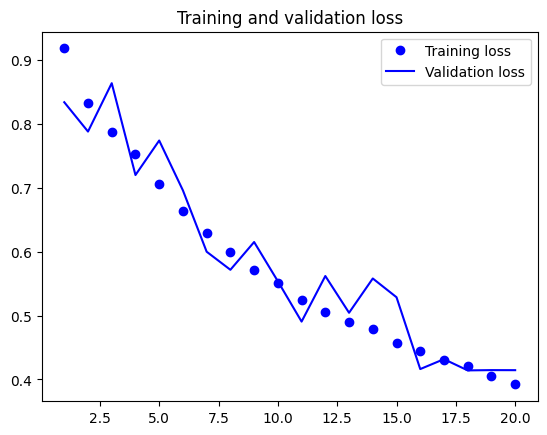

In [6]:
# plot training and vaidation loss 
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
